#Imports

In [ ]:
import urllib.request
import os
import numpy as np
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import re, string
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

from sklearn.metrics import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import plot_tree
import nltk
from scipy import sparse
import seaborn as sns
from matplotlib import cm

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read dataset

In [ ]:
df_sentiment = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/sentiment.csv")
df_test_raw = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_test.csv")
df_train_raw = pd.read_csv("/content/drive/Shareddrives/TextAnalytics_project/dataset_ironita_2018/Data/processed_text_train.csv")

In [ ]:
sentiment = df_sentiment[["id", "sentiment", "emotion"]]

In [ ]:
df_train = pd.merge(df_train_raw, sentiment, on="id", how="left")
df_test = pd.merge(df_test_raw, sentiment, on="id", how="left")

In [ ]:
df_train.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag,sentiment,emotion
0,8.111568e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...,negative,fear
1,8.111831e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...,negative,fear
2,8.263806e+17,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0.0,0.0,HSC,zingaro solito merdoso #cacciamolivia Roma rom...,zingari soliti merdosi #cacciamolivia roma rom...,zingari soliti merdosi @hashtag roma rom aggre...,negative,anger
3,8.448712e+17,"Zingari di merda,tutti al muro...bastardi Spar...",0.0,0.0,HSC,zingaro merda muro bastardo sparare carabinier...,zingari merda muro bastardi sparano carabinier...,zingari merda muro bastardi sparano carabinier...,negative,anger
4,5.097128e+17,zero notizie decreto #tfaordinario II ciclo ze...,1.0,0.0,TW-BS,zero notizia decreto #tfaordinario II ciclo ze...,zero notizie decreto #tfaordinario ii ciclo ze...,zero notizie decreto @hashtag ii ciclo zero no...,negative,fear


In [ ]:
df_test.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag,sentiment,emotion
0,5.955245e+17,-Prendere i libri in copisteria-Fare la spesa-...,1.0,0.0,TWITA,prendere libro copisteria spesa Sparare bocca ...,prendere libri copisteria spesa spararmi bocca...,prendere libri copisteria spesa spararmi bocca...,negative,anger
1,5.784681e+17,...comunque con una crociera Costa se non ti a...,1.0,0.0,HSC,comunque crociera Costa ammazzare schettino pr...,comunque crociera costa ammazza schettino prim...,comunque crociera costa ammazza schettino prim...,negative,anger
2,5.777915e+17,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1.0,1.0,TWITA,@TweetComici ogni ragazza ragazza geloso @numb...,@tweetcomici ogni ragazza ragazza gelosa @numb...,@mention ogni ragazza ragazza gelosa @number m...,negative,anger
3,5.074649e+17,“La buona scuola”? Fa gli errori di grammatica...,0.0,0.0,TW-BS,buono scuola errore grammatica @url,buona scuola fa errori grammatica @url,buona scuola fa errori grammatica @url,negative,anger
4,8.398961e+17,“Vi hanno sfrattato? Andate al campo rom in un...,0.0,0.0,HSC,sfrattare andare campo rom container @number f...,sfrattato andate campo rom container @number f...,sfrattato andate campo rom container @number f...,negative,anger


Sentiments and Emotions distribution

In [ ]:
df_train["sentiment"].value_counts()

negative    2962
positive    1015
Name: sentiment, dtype: int64

In [ ]:
df_test["sentiment"].value_counts()

negative    554
positive    318
Name: sentiment, dtype: int64

In [ ]:
df_train["emotion"].value_counts()

anger      2688
joy         821
fear        287
sadness     181
Name: emotion, dtype: int64

In [ ]:
df_test["emotion"].value_counts()

anger      489
joy        267
sadness     60
fear        56
Name: emotion, dtype: int64

Let's transform our new features in dummies

In [ ]:
df_train["sentiment_bin"] = df_train["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
df_train = pd.get_dummies(df_train, prefix='', prefix_sep='',columns=["emotion"])
df_train.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag,sentiment,sentiment_bin,anger,fear,joy,sadness
0,8.111568e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...,negative,0,0,1,0,0
1,8.111831e+17,"Zurigo, trovato morto il presunto autore della...",0.0,0.0,HSC,Zurigo trovare morire presumere autore sparato...,zurigo trovato morto presunto autore sparatori...,zurigo trovato morto presunto autore sparatori...,negative,0,0,1,0,0
2,8.263806e+17,"Zingari..i soliti ""MERDOSI""..#cacciamolivia Ro...",0.0,0.0,HSC,zingaro solito merdoso #cacciamolivia Roma rom...,zingari soliti merdosi #cacciamolivia roma rom...,zingari soliti merdosi @hashtag roma rom aggre...,negative,0,1,0,0,0
3,8.448712e+17,"Zingari di merda,tutti al muro...bastardi Spar...",0.0,0.0,HSC,zingaro merda muro bastardo sparare carabinier...,zingari merda muro bastardi sparano carabinier...,zingari merda muro bastardi sparano carabinier...,negative,0,1,0,0,0
4,5.097128e+17,zero notizie decreto #tfaordinario II ciclo ze...,1.0,0.0,TW-BS,zero notizia decreto #tfaordinario II ciclo ze...,zero notizie decreto #tfaordinario ii ciclo ze...,zero notizie decreto @hashtag ii ciclo zero no...,negative,0,0,1,0,0


In [ ]:
df_test["sentiment_bin"] = df_test["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
df_test = pd.get_dummies(df_test, prefix='', prefix_sep='',columns=["emotion"])
df_test.head()

,id,text,irony,sarcasm,topic,lemmatized_text,cleaned_text,cleaned_text_mention_hashtag,sentiment,sentiment_bin,anger,fear,joy,sadness
0,5.955245e+17,-Prendere i libri in copisteria-Fare la spesa-...,1.0,0.0,TWITA,prendere libro copisteria spesa Sparare bocca ...,prendere libri copisteria spesa spararmi bocca...,prendere libri copisteria spesa spararmi bocca...,negative,0,1,0,0,0
1,5.784681e+17,...comunque con una crociera Costa se non ti a...,1.0,0.0,HSC,comunque crociera Costa ammazzare schettino pr...,comunque crociera costa ammazza schettino prim...,comunque crociera costa ammazza schettino prim...,negative,0,1,0,0,0
2,5.777915e+17,"“@TweetComici: Ogni ragazza: \""non sono una ra...",1.0,1.0,TWITA,@TweetComici ogni ragazza ragazza geloso @numb...,@tweetcomici ogni ragazza ragazza gelosa @numb...,@mention ogni ragazza ragazza gelosa @number m...,negative,0,1,0,0,0
3,5.074649e+17,“La buona scuola”? Fa gli errori di grammatica...,0.0,0.0,TW-BS,buono scuola errore grammatica @url,buona scuola fa errori grammatica @url,buona scuola fa errori grammatica @url,negative,0,1,0,0,0
4,8.398961e+17,“Vi hanno sfrattato? Andate al campo rom in un...,0.0,0.0,HSC,sfrattare andare campo rom container @number f...,sfrattato andate campo rom container @number f...,sfrattato andate campo rom container @number f...,negative,0,1,0,0,0


#Train and test

In [ ]:
X_train = df_train['cleaned_text_mention_hashtag']
X_test = df_test['cleaned_text_mention_hashtag']

y_train = df_train['irony'].values
y_test = df_test['irony'].values

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
def nltk_ngram_tokenizer(text):
    tt= TweetTokenizer()
    all_tokens = list()

    tokens = tt.tokenize(text)


    # we use a simple nltk function to create ngrams
    if len(tokens) >= 2:
      bigrams = ['BI_'+w1+'_'+w2 for w1,w2 in nltk.ngrams(tokens,2)]
      trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(tokens,3)]
      all_tokens.extend(bigrams)
      all_tokens.extend(trigrams)

    all_tokens.extend(tokens)

    return all_tokens

#Decision Tree

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=500)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tfidf= pipe.fit_transform(X_train, y_train)
X_test_tfidf= pipe.transform(X_test)
print(X_train_tfidf.shape, X_test_tfidf.shape)

(3977, 500) (872, 500)


In [ ]:
X_train_final = sparse.csr_matrix(np.c_[X_train_tfidf.toarray(), df_train['sentiment_bin'].values, df_train['anger'].values, df_train['fear'].values, df_train['joy'].values, df_train['sadness'].values])
X_test_final = sparse.csr_matrix(np.c_[X_test_tfidf.toarray(), df_test['sentiment_bin'].values, df_test['anger'].values, df_test['fear'].values, df_test['joy'].values, df_test['sadness'].values])

In [ ]:
X_train_final.shape, X_test_final.shape

((3977, 505), (872, 505))

Grid Search

In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 40}

In [ ]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth=10, min_samples_leaf=5, min_samples_split=40, random_state=0)
clf.fit(X_train_final, y_train)

y_pred= clf.predict(X_train_final)
y_pred_test= clf.predict(X_test_final)

In [ ]:
print(classification_report(y_pred, y_train))

              precision    recall  f1-score   support

         0.0       0.67      0.73      0.69      1796
         1.0       0.76      0.70      0.73      2181

    accuracy                           0.71      3977
   macro avg       0.71      0.71      0.71      3977
weighted avg       0.72      0.71      0.71      3977



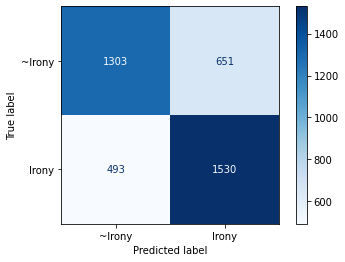

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_pred_test, y_test))

              precision    recall  f1-score   support

         0.0       0.63      0.70      0.66       394
         1.0       0.72      0.66      0.69       478

    accuracy                           0.68       872
   macro avg       0.68      0.68      0.67       872
weighted avg       0.68      0.68      0.68       872



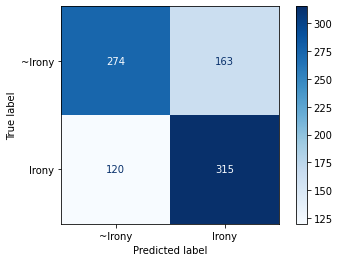

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony'], cmap=plt.cm.Blues)
plt.show()

##Feature Importance

In [ ]:
selector= pipe.named_steps['selbestk']
vect= pipe.named_steps['vect']

In [ ]:
features = np.concatenate([np.array(vect.get_feature_names())[selector.get_support()], np.array(["sentiment_bin",	"anger", "fear", "joy", "sadness"])])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dict_features = dict(zip(features, clf.feature_importances_))

In [ ]:
list_features_sorted = list(sorted(dict_features.items(), key = lambda i: i[1], reverse=True))

In [ ]:
feature_to_plot = pd.DataFrame(list_features_sorted[:5], columns=['Feature','Importance'])

In [ ]:
list_features_to_append= ["sentiment_bin", "anger", "fear", "joy", "sadness"]
for feat in list_features_to_append:
  feature_to_plot.loc[len(feature_to_plot)] = [feat, dict_features[feat]]

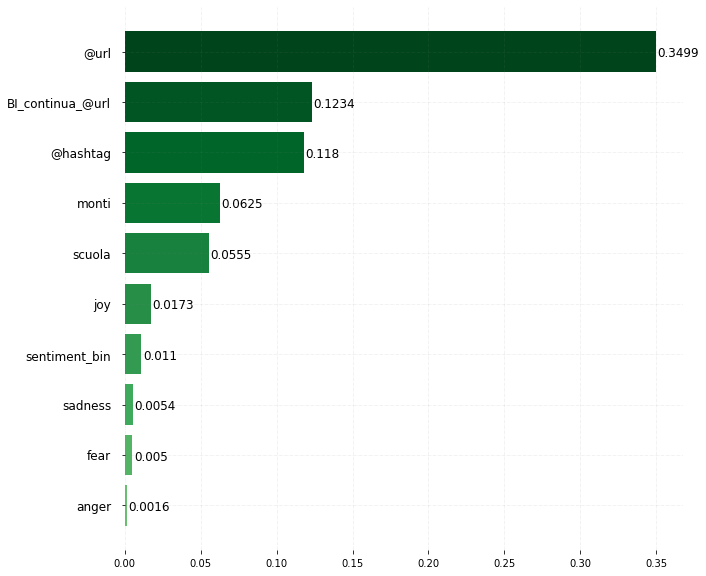

In [ ]:
nbr_features = 20

tree_feature_importances = feature_to_plot["Importance"]
sorted_idx = (-tree_feature_importances).argsort()[-nbr_features:]
colors = cm.Greens(np.linspace(1, 0, 20))
y_ticks = np.arange(0, len(sorted_idx))

fig, ax = plt.subplots(figsize=(10, 10))
  
# Horizontal Bar Plot
ax.barh(y_ticks, tree_feature_importances[sorted_idx], color=colors)
plt.yticks(y_ticks, np.array(feature_to_plot["Feature"])[sorted_idx])
  
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
  
  
# Add padding between axes and labels
ax.tick_params(axis='y', labelsize= 12)
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
  
# Add x, y gridlines
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
  
# Show top values
ax.invert_yaxis()
  
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.001, i.get_y()+0.5,
             str(round((i.get_width()), 4)),
             fontsize=12)
    
# Show Plot
plt.show()

#Decision Tree (multiclass)

In [ ]:
X_train = df_train['cleaned_text_mention_hashtag']
y_train = df_train[['irony','sarcasm']].values

In [ ]:
X_test = df_test['cleaned_text_mention_hashtag']
y_test = df_test[['irony','sarcasm']].values

In [ ]:
y_train= y_train.sum(axis=1)
y_test= y_test.sum(axis=1)

In [ ]:
pipe = Pipeline([("vect", CountVectorizer(analyzer=nltk_ngram_tokenizer, min_df=2)),
                ("selbestk", SelectKBest(score_func = chi2, k=200)),
                ("tfidf", TfidfTransformer())
                ])

X_train_tok= pipe.fit_transform(X_train, y_train)
X_test_tok= pipe.transform(X_test)
print(X_train_tok.shape, X_test_tok.shape)

(3977, 200) (872, 200)


In [ ]:
X_train_final = sparse.csr_matrix(np.c_[X_train_tok.toarray(), df_train['sentiment_bin'].values, df_train['anger'].values, df_train['fear'].values, df_train['joy'].values, df_train['sadness'].values])
X_test_final = sparse.csr_matrix(np.c_[X_test_tok.toarray(), df_test['sentiment_bin'].values, df_test['anger'].values, df_test['fear'].values, df_test['joy'].values, df_test['sadness'].values])

In [ ]:
X_train_final.shape, X_test_final.shape

((3977, 205), (872, 205))

In [ ]:
param_grid={
    'criterion': ["gini", "entropy"],
    'max_depth': np.arange(10,50,5), 
    'min_samples_split': np.arange(5,70,5),
    'min_samples_leaf': np.arange(5,70,5)
}

In [ ]:
grid= GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, scoring='f1_macro', cv=StratifiedKFold(n_splits=5, shuffle=True))
grid.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                         'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]),
                         'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65])},
             scoring='f1_macro')

In [ ]:
report(grid.cv_results_, n_top=5)

In [ ]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_leaf': 20,
 'min_samples_split': 5}

In [ ]:
clf= DecisionTreeClassifier(criterion='entropy', max_depth=45, min_samples_leaf=5, min_samples_split=30)
clf.fit(X_train_final, y_train)

y_pred= clf.predict(X_train_final)
y_pred_test= clf.predict(X_test_final)

In [ ]:
print(classification_report(y_train, y_pred, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.71      0.84      0.77      1954
       Irony       0.59      0.55      0.57      1110
     Sarcasm       0.64      0.42      0.51       913

    accuracy                           0.67      3977
   macro avg       0.65      0.61      0.62      3977
weighted avg       0.66      0.67      0.65      3977



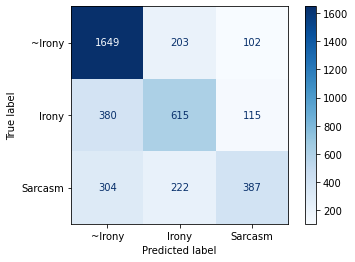

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_test, target_names=['~Irony','Irony','Sarcasm']))

              precision    recall  f1-score   support

      ~Irony       0.64      0.70      0.67       437
       Irony       0.35      0.44      0.39       219
     Sarcasm       0.42      0.23      0.29       216

    accuracy                           0.52       872
   macro avg       0.47      0.46      0.45       872
weighted avg       0.51      0.52      0.50       872



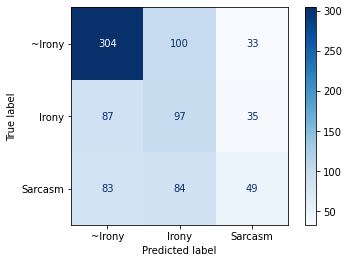

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=['~Irony','Irony','Sarcasm'], cmap=plt.cm.Blues)
plt.show()

##Feature Importance

In [ ]:
selector= pipe.named_steps['selbestk']
vect= pipe.named_steps['vect']

In [ ]:
features = np.concatenate([np.array(vect.get_feature_names())[selector.get_support()], np.array(["sentiment_bin",	"anger", "fear", "joy", "sadness"])])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
dict_features = dict(zip(features, clf.feature_importances_))

In [ ]:
list_features_sorted = list(sorted(dict_features.items(), key = lambda i: i[1], reverse=True))

In [ ]:
feature_to_plot_multi = pd.DataFrame(list_features_sorted[:5], columns=['Feature','Importance'])

In [ ]:
list_features_to_append= ["sentiment_bin", "anger", "fear", "joy", "sadness"]
for feat in list_features_to_append:
  feature_to_plot_multi.loc[len(feature_to_plot_multi)] = [feat, dict_features[feat]]

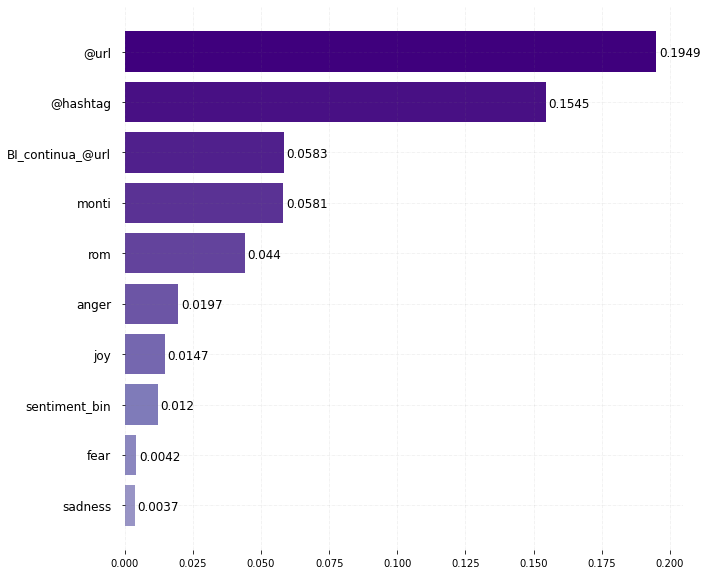

In [ ]:
nbr_features = 20

tree_feature_importances = feature_to_plot_multi["Importance"]
sorted_idx = (-tree_feature_importances).argsort()[-nbr_features:]
colors = cm.Purples(np.linspace(1, 0, 20))
y_ticks = np.arange(0, len(sorted_idx))

fig, ax = plt.subplots(figsize=(10, 10))
  
# Horizontal Bar Plot
ax.barh(y_ticks, tree_feature_importances[sorted_idx], color=colors)
plt.yticks(y_ticks, np.array(feature_to_plot_multi["Feature"])[sorted_idx])
  
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
  
  
# Add padding between axes and labels
ax.tick_params(axis='y', labelsize= 12)
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
  
# Add x, y gridlines
ax.grid(b=True, color='grey',
        linestyle='-.', linewidth=0.5,
        alpha=0.2)
  
# Show top values
ax.invert_yaxis()
  
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.001, i.get_y()+0.5,
             str(round((i.get_width()), 4)),
             fontsize=12)
    
# Show Plot
plt.show()

Aggregated values of sentiment/emotion features importance

Binary

In [ ]:
round(feature_to_plot["Importance"][5:].sum(), 4)

0.0402

Multi class

In [ ]:
round(feature_to_plot_multi["Importance"][5:].sum(), 4)

0.0544